# Diabetes Readmission – Modeling Preprocessing & Feature Engineering

## 1. Introduction

We're going to pick up with where we left off in our portfolio cleaning notebook. We did a little bit of exploratory data analysis and basic cleaning, but as the paths diverged from building a model to explain and models to predict, our needs diverged.  

Our overall goal is to build several predictive models for readmission to the hospital after diabetic interactions. While the paper authors focused on interpretability of their logistic regression in support of particular medical domain interest claims, we're just going to focus on building well-behaved, non-overfitted predictive models with a variety of state of the art techniques.

## 2. Load Cleaned Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import special

In [2]:
diabetes = pd.read_pickle('../data/diabetes_clean.pkl')

## 3. Exploratory Analysis: Outliers & Distributions

We need to do a little more data understanding before we get into preparation proper. We already more or less handled data quality issues in our initial cleaning. We can thus go ahead and take a look at outliers. 

### 3.1 Outlier analysis

Let's start by taking a look at our numeric values and their distributions. 


In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  int64 
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51806 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

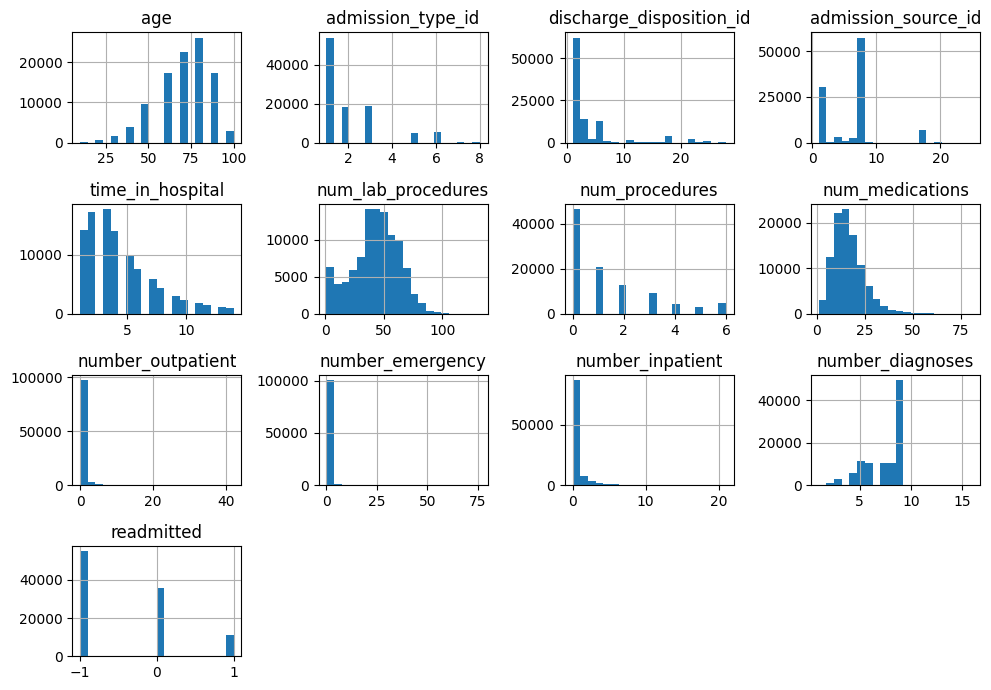

In [4]:
numeric_cols = diabetes.columns[diabetes.dtypes == 'int64'].tolist()
numeric_cols.remove('encounter_id')
numeric_cols.remove('patient_nbr')

diabetes[numeric_cols].hist(figsize=(10, 7), bins=20)
plt.tight_layout()

We can see that we might want to do some transformations on time in hospital, num medications, and the number_ variables, depending on the type of modeling approach taken.

Let's take a look at our non-numerics now. We have removed medical specialty/subspecialty and the diagnostic codes for readability.

#### 3.1.1 Distribution Analysis Summary

The histograms reveal several important patterns in our numeric features:

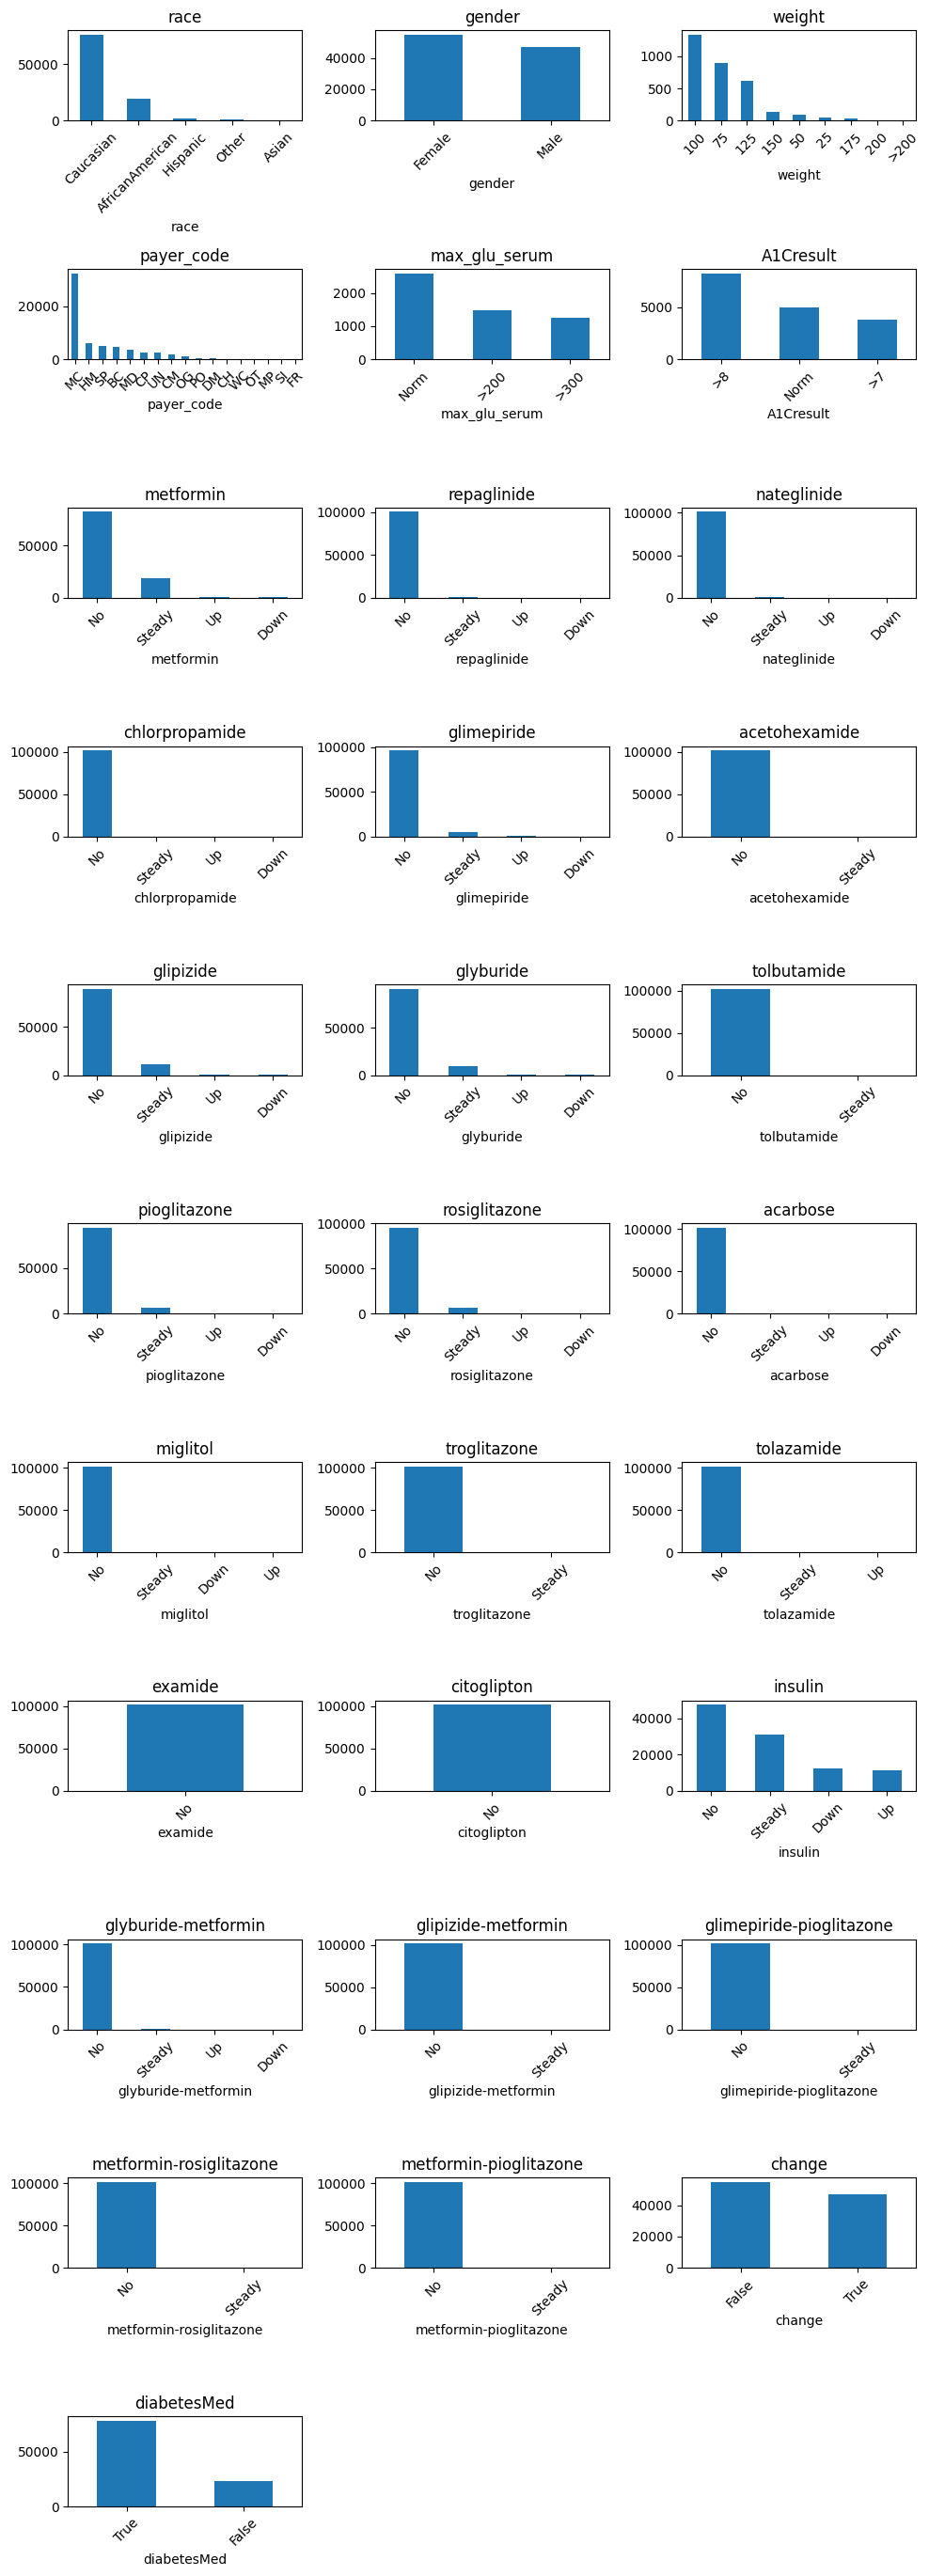

In [5]:
non_num = diabetes.columns[diabetes.dtypes != "int64"].tolist()

# Remove unreadable columns
exclude_cols = [
    "diag_1",
    "diag_2",
    "diag_3",
    "medical_specialty",
    "medical_subspecialty",
    "discharge_disposition_group",
    "admission_source_group",
]
non_num = [col for col in non_num if col not in exclude_cols]

fig, axes = plt.subplots(
    nrows=int(np.ceil(len(non_num) / 3)),
    ncols=3,
    figsize=(10, 2.5 * int(np.ceil(len(non_num) / 3))),
)
axes = axes.flatten()

for i, col in enumerate(non_num):
    diabetes[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=45)

for i in range(len(non_num), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()

plt.show()

1) Examide, citoglipton are all "no's" and probably should be dropped
2) acetohexamide, tolbutamide, acarbose, miglitol, troglitazone, glipizide-metformin, glimepiride-ppioglitazone, metformin-rosiglitazone, metformin-pioglitazone are all so unbalanced they should also probably be dropped
3) repaglinide, nateglinide, chloropropamide, are also pretty unbalanced and are candidates to be dropped

## 4. Missing Data Summary

In [6]:
# Load data quality reference
variables = pd.read_csv('../data/variables.csv')

In [7]:
# Calculate missing value statistics for variables marked as having missing data
variables.loc[variables["Missing Values"] == "yes", "missing_num"] = (
    diabetes[variables.loc[variables["Missing Values"] == "yes", "Variable Name"]]
    .isna()
    .sum()
    .values
)

variables.loc[variables["Missing Values"] == "yes", "missing_percent"] = (
    diabetes[variables.loc[variables["Missing Values"] == "yes", "Variable Name"]]
    .isna()
    .sum()
    .values / len(diabetes) * 100
)

variables[variables['Missing Values'] == 'yes']

,Variable Name,Role,Type,Demographic,Description,Units,Missing Values,missing_num,missing_percent
2,race,Feature,Categorical,Race,"Values: Caucasian, Asian, African American, Hi...",NaN,yes,2273.0,2.233555
5,weight,Feature,Categorical,NaN,Weight in pounds.,NaN,yes,98569.0,96.858479
10,payer_code,Feature,Categorical,NaN,Integer identifier corresponding to 23 distinc...,NaN,yes,40256.0,39.557416
11,medical_specialty,Feature,Categorical,NaN,Integer identifier of a specialty of the admit...,NaN,yes,49960.0,49.093017
18,diag_1,Feature,Categorical,NaN,The primary diagnosis (coded as first three di...,NaN,yes,21.0,0.020636
19,diag_2,Feature,Categorical,NaN,Secondary diagnosis (coded as first three digi...,NaN,yes,358.0,0.351787
20,diag_3,Feature,Categorical,NaN,Additional secondary diagnosis (coded as first...,NaN,yes,1423.0,1.398306


- It is likely that we cannot address the weight data effectively. 
- The payer code is not translated in the provided IDS_mapping.csv, making it difficult to determine its significance.
- The absence of data on medical specialties is unfortunate, but we did include specialty and subspecialty columns in our initial data cleaning.

Overall, I believe that we have limited options for addressing the missing values in this dataset. Unlike other datasets where we may have variables with minor missingness that could be imputed, the missing data in this dataset is severe, and imputation would likely introduce further complications.


## 5. Feature Engineering

We've already engineered one feature - inferring a substitution in medication based on change & the other medication columns. We should seek other possible features to engineer. We know that the diagnosis codes are ripe for this; there may be some engineering that could be done with regards to the patient's prior history as well.

### 5.1 Diagnostic Code Groupings (ICD-9)

The ICD9 system is very structured and defines high level and subgroups, like so:

 - 001–139: infectious and parasitic diseases
    - Intestinal infectious diseases (001–009)
    - Tuberculosis (010–018)
    - Zoonotic bacterial diseases (020–027)
    - Other bacterial diseases (030–041)
    - (others) (042 - 139)
 - 140–239: neoplasms
 - 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
 - (... etc)

This hierarchical structure allows clustering of related codes based on their proximity in the classification tree. 

As the categories and subcategories defined by ICD9 aren't consistent in numbering (they aren't all ranges of 10/20, etc.), we have defined a lookup reference for these categories and will apply it to the dataset here.

The structured categories were modified from the original at https://github.com/sirrice/icd9.

As different modeling techniques are better suited to different feature creation approaches, we'll set up families of approaches for later inclusion in modeling efforts.

#### 5.1.1 Mapping creation

In [8]:
# Load ICD-9 diagnostic code hierarchy from preprocessed JSON
icd_codes = pd.read_json('../data/filtered_codes.json')
icd_codes.tail()

,code,descr,depth
473,E992,INJURY DUE TO WAR OPERATIONS BY EXPLOSION OF M...,2
474,E990,INJURY DUE TO WAR OPERATIONS BY FIRES AND CONF...,2
475,E991,INJURY DUE TO WAR OPERATIONS BY BULLETS AND FR...,2
476,E997,INJURY DUE TO WAR OPERATIONS BY OTHER FORMS OF...,2
477,E999,LATE EFFECT OF INJURY DUE TO WAR OPERATIONS AN...,2


Recall that from our cleaning effort, we ended up with strings of three to five characters:
- E codes are four characters; 
- V codes are three characters; 
- non- E or V codes three to five characters.

We need to match our codes.

#### 5.1.2 Code Matching Strategy

Our diagnostic codes need to be mapped to the ICD-9 hierarchy. The challenge is handling the different code formats:

In [9]:
# Build mapping
diag_group_mapping = {}
diag_subgroup_mapping = {}
for _, code_info in icd_codes.iterrows():
    code = code_info["code"]
    descr = code_info["descr"]
    depth = code_info["depth"]

    mapping_dict = diag_group_mapping if depth == 1 else diag_subgroup_mapping

    # Parse range like '001-139'
    try:
        start, end = code.split("-")
        try:
            for i in range(int(start), int(end) + 1):
                mapping_dict[str(i)] = code
        except:  # v or E code
            for i in range(int(start.lstrip("VE")), int(end.lstrip("VE")) + 1):
                mapping_dict[(start[0] + str(i))] = code
    except:  # not dashed - top level code is also 2nd level code
        mapping_dict[code] = code

#### 5.1.3 Feature sets
Now that we have our mapping we can define applications, each suited best for a different modeling style.

In [10]:
# Single consolidated diagnosis feature (e.g., linear models)
def diag_consolidated_features(data):
    # Combine all diagnoses into one feature per level
    data['primary_group'] = data['diag_1'].map(diag_group_mapping)
    data['primary_subgroup'] = data['diag_1'].map(diag_subgroup_mapping)

    data['secondary_group'] = data['diag_2'].map(diag_group_mapping)
    data['secondary_subgroup'] = data['diag_2'].map(diag_subgroup_mapping)

    data['secondary2_group'] = data['diag_3'].map(diag_group_mapping)
    data['secondary2_subgroup'] = data['diag_3'].map(diag_subgroup_mapping)
    
    return data


In [11]:
# Binary indicator columns (one-hot style)
def diag_binary_features(data):
    top_level_groups = icd_codes[icd_codes['depth']==1]

    # Create all binary columns at once
    binary_cols = {}

    for _, group_info in top_level_groups.iterrows():
        code_range = group_info['code']
        descr = group_info['descr']
        clean_code = code_range.replace('-', '_')

        # Check if any diagnosis falls in this range
        binary_cols[f'has_{clean_code}'] = (
            (data['diag_1'].map(diag_group_mapping).fillna('') == descr) |
            (data['diag_2'].map(diag_group_mapping).fillna('') == descr) |
            (data['diag_3'].map(diag_group_mapping).fillna('') == descr)
        ).astype(int)
        
    binary_df = pd.DataFrame(binary_cols, index=data.index)
    return pd.concat([data, binary_df], axis=1)

In [12]:
# Count-based features:
def diag_count_features(data):
    top_level_groups = icd_codes[icd_codes['depth']==1]

    count_cols = {}

    for _, group_info in top_level_groups.iterrows():
        code_range = group_info['code']
        clean_code = code_range.replace('-', '_')

        # Count how many diagnoses fall in this range
        count_cols[f'count_{clean_code}'] = (
            data['diag_1'].map(diag_group_mapping).notna().astype(int) *
            (data['diag_1'].map(diag_group_mapping) == group_info['descr']).astype(int) +
            data['diag_2'].map(diag_group_mapping).notna().astype(int) *
            (data['diag_2'].map(diag_group_mapping) == group_info['descr']).astype(int) +
            data['diag_3'].map(diag_group_mapping).notna().astype(int) *
            (data['diag_3'].map(diag_group_mapping) == group_info['descr']).astype(int)
        )

    count_df = pd.DataFrame(count_cols, index=data.index)
    return pd.concat([data, count_df], axis=1)

### 5.2 Discharge Disposition Grouping

We are given a mapping of the discharge_disposition_id with the dataset. We can generally group these into a few high level categories:

  1. Home/Self-Care:
  - 1: Discharged to home
  - 6: Home with home health service
  - 8: Home under care of Home IV provider

  2. Transfer to Another Facility:
  - 2: Another short term hospital
  - 3: SNF (Skilled Nursing Facility)
  - 4: ICF (Intermediate Care Facility)
  - 5: Another inpatient care institution
  - 22: Rehab facility
  - 23: Long term care hospital
  - 24: Nursing facility (Medicaid only)
  - 27: Federal health care facility
  - 28: Psychiatric hospital
  - 29: Critical Access Hospital
  - 30: Other health care institution

  3. End-of-Life/Hospice:
  - 11: Expired
  - 13: Hospice/home
  - 14: Hospice/medical facility
  - 19: Expired at home (Medicaid hospice)
  - 20: Expired in medical facility (Medicaid hospice)
  - 21: Expired, place unknown (Medicaid hospice)

  4. Continued Care/Readmission:
  - 9: Admitted as inpatient to this hospital
  - 12: Still patient/expected to return
  - 15: Medicare swing bed within institution
  - 16: Referred to another institution for outpatient
  - 17: Referred to this institution for outpatient

  5. Other/Problem Discharges:
  - 7: Left AMA (Against Medical Advice)
  - 10: Neonate to another hospital
  - 18: NULL
  - 25: Not Mapped
  - 26: Unknown/Invalid

  This creates 5 meaningful categories for modeling readmission risk.

In [13]:
# Create discharge disposition mapping - see IDS_mapping.csv for descriptions
discharge_groups = {
    'Home/Self-Care': [1, 6, 8],
    'Transfer to Another Facility': [2, 3, 4, 5, 22, 23, 24, 27, 28, 29, 30],
    'End-of-Life/Hospice': [11, 13, 14, 19, 20, 21],
    'Continued Care/Readmission': [9, 12, 15, 16, 17],
    'Other/Problem Discharges': [7, 10, 18, 25, 26]
}

# Flatten to mapping dict
discharge_mapping = {id: group for group, ids in discharge_groups.items() for id in ids}

# Apply mapping
diabetes['discharge_disposition_group'] = diabetes['discharge_disposition_id'].map(discharge_mapping)

### 5.3 Admission Source Grouping

In a similar fashion we can group admission sources. 

In [14]:
admission_groups = {
    'Emergency/Urgent': [7, 8],  # Emergency Room, Court/Law Enforcement
    'Referral': [1, 2, 3],  # Physician, Clinic, HMO Referral
    'Transfer from Healthcare Facility': [4, 5, 6, 10, 18, 22, 25, 26],  # Hospitals, SNF, other facilities
    'Maternity/Birth': [11, 12, 13, 14, 23, 24],  # Deliveries, sick baby, births
    'Home Health': [19],  # Readmission to Same Home Health Agency
    'Unknown/Other': [9, 15, 17, 20, 21]  # Not Available, NULL, Not Mapped, Unknown
}

# Flatten to mapping dict
admission_mapping = {id: group for group, ids in admission_groups.items() for id in ids}

# Apply mapping
diabetes['admission_source_group'] = diabetes['admission_source_id'].map(admission_mapping)

### 5.4 A1C Test Indicator

With a lot of missing values, we can group the HbA1c into 'test was performed' or not.

In [15]:
diabetes['A1C_tested'] = ~diabetes['A1Cresult'].isna()

### 5.5 Service Utilization Score

number outpatient, number emergency, and number inpatient all refer to various types of healthcare service utilizations by the patients. We can sum those into a single utilization score.


In [16]:
diabetes["service_utilization"] = (
    diabetes["number_inpatient"]
    + diabetes["number_outpatient"]
    + diabetes["number_emergency"]
)

### 5.6 Medication Substitution Detection

We are told 'changes' indicates changes in medication or moves from name-brand to generic. Let's see what this looks like and if we can engineer a substitution feature.

In [17]:
medications = diabetes.iloc[:, 24:47].columns

# If every column is a 'No' or 'Steady', we'd expect 'change' to be No, otherwise, 'Yes'.
meds_unchanged = (diabetes[medications].isin(["No", "Steady"])).sum(axis=1) == len(medications)

# We expect this to be the same number as the length of the dataset, but it isn't
print((diabetes["change"] == ~meds_unchanged).sum())

82458


This aligns with about 80% of our data. Reading the documentation about the variables -

*"Indicates if there was a change in diabetic medications (either dosage or generic name). 
Values: change and no change"*

From this we will infer that if no changes are reported across the 23 medication columns,
the patient was moved from a generic to a name-brand or vice/versa and create this engineered feature.

In [18]:
# Here's the first case in the dataset.
diabetes.loc[(diabetes["change"] == meds_unchanged), medications.tolist() + ['change']].head(1).stack()

4  metformin                       No
   repaglinide                     No
   nateglinide                     No
   chlorpropamide                  No
   glimepiride                     No
   acetohexamide                   No
   glipizide                   Steady
   glyburide                       No
   tolbutamide                     No
   pioglitazone                    No
   rosiglitazone                   No
   acarbose                        No
   miglitol                        No
   troglitazone                    No
   tolazamide                      No
   examide                         No
   citoglipton                     No
   insulin                     Steady
   glyburide-metformin             No
   glipizide-metformin             No
   glimepiride-pioglitazone        No
   metformin-rosiglitazone         No
   metformin-pioglitazone          No
   change                        True
dtype: object

In [19]:
diabetes['substitution'] = (diabetes["change"] == meds_unchanged)

### 5.7 Medication Change Count

There's a lot of medication columns; let's roll this up into a single numeric.

In [20]:
diabetes['med_change_count'] = len(medications) - (diabetes[medications].isin(["No", "Steady"])).sum(axis=1)

### 5.8 Non-Diabetic Medication Count

Similarly, we can see how many diabetes meds were used in the hospital stay, and turn our num_medications into num_nondiabetic_medications, as it's the count of # of medications *total* used during the stay:

In [21]:
diabetes['diabetes_meds_used'] = len(medications) - (diabetes[medications].isin(["No"])).sum(axis=1)

# (diabetes['num_medications'] - diabetes['meds_used']).value_counts()
diabetes['num_nondiabetic_medications'] = diabetes['num_medications'] - diabetes['diabetes_meds_used']

diabetes['diabetes_meds_used'].value_counts() # nothing below zero.

diabetes_meds_used
1    47314
0    23403
2    21873
3     7778
4     1335
5       58
6        5
Name: count, dtype: int64

## 6. Feature Transformation
### 6.1 Age Binning

We had *cleaned* the age factor up - the value is the top of the bins from the original dataset. We can bin this further; the original paper authors used age bins based on domain expertise; we will use those here as well.

In [22]:
# Age factor engineering
diabetes['age_group'] = np.select([
    diabetes['age'] <= 29,
    diabetes['age'].between(30, 59),
    diabetes['age'] >= 60
], [
    '<30',
    '30-60',
    '>60'
], default='Unknown')

### 6.2 Readmission Reclassification (Binary Target)

We had initially given three numerical values to readmission. We're going to go ahead and flatten that down into two. It could be interesting to try to fit a trinary classifier, but not in scope for now.

In [23]:
diabetes["readmitted"] = diabetes["readmitted"].map({-1: 0, 0: 1, 1: 1})

### 6.3 Skewed Feature Box-Cox Transformations

Not every technique we will use requires numerical transformations, but some will. We will thus create some transformation functional wrappers, which can be passed ahead of modeling calls, similar to how we set up our diagnostic code functions.

##### 6.3.1 Skew/kurtosis investigation
Lets investigate skew and kurtosis for our numeric variables.

In [24]:
numeric_cols = diabetes.columns[diabetes.dtypes == 'int64'].tolist()[6:]
numeric_cols

num_characteristics = pd.DataFrame({
    'skew': diabetes[numeric_cols].skew(),
    'kurtosis':diabetes[numeric_cols].kurtosis()
})
num_characteristics

,skew,kurtosis
time_in_hospital,1.133999,0.850251
num_lab_procedures,-0.236544,-0.245074
num_procedures,1.316415,0.857110
num_medications,1.326672,3.468155
number_outpatient,8.832959,147.907736
number_emergency,22.855582,1191.686726
number_inpatient,3.614139,20.719397
number_diagnoses,-0.876746,-0.079056
readmitted,0.156960,-1.975402
service_utilization,5.315210,67.180278


We will transform using box/cox for kurtosis over 2 for models that need it:

In [25]:
skew_cols = [
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "service_utilization",
    "num_nondiabetic_medications",
]

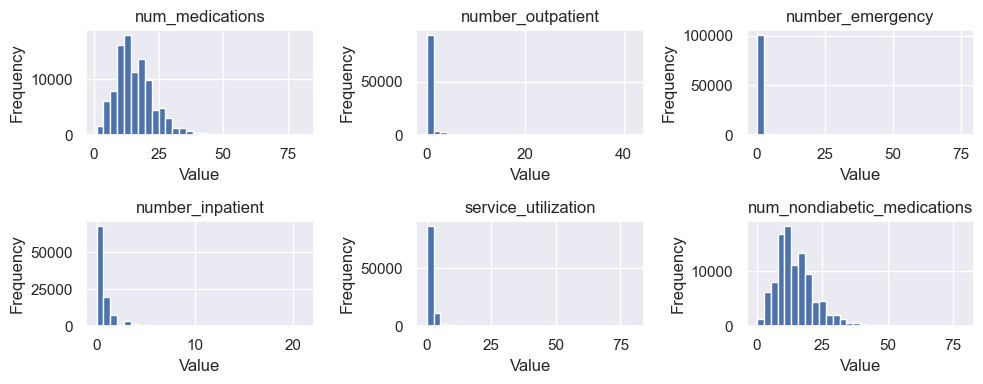

In [26]:
# Pre-transformation

sns.set_theme('notebook')

fig, axes = plt.subplots(2, 3, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(skew_cols):
    diabetes[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
def log_transform(data):
    for col in skew_cols:
        try:
            #print(f"Checking {col}: min={data[col].min()}, max={data[col].max()}, has_na={data[col].isna().any()}")
            data[col], _ = stats.boxcox(data[col] + 1)
        except Exception as e:
            print(f"error: {col} - {e}")
    return data

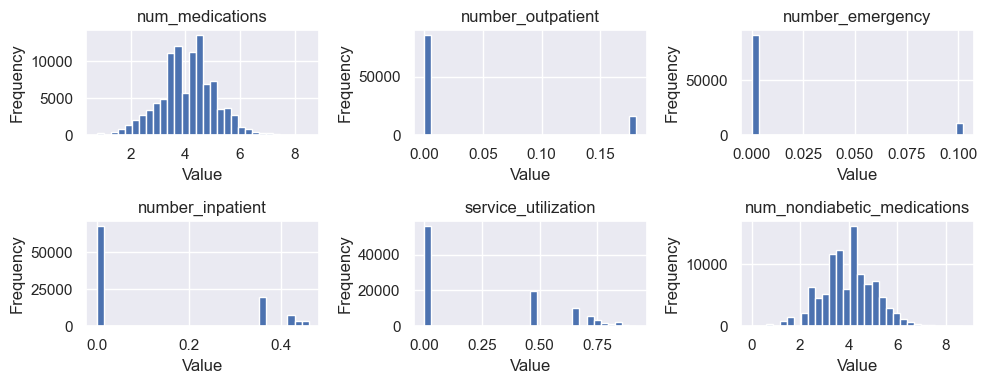

In [28]:
# Post-transformation

fig, axes = plt.subplots(2, 3, figsize=(10, 4))

axes = axes.flatten()
plot_transformed = log_transform(diabetes)

for i, col in enumerate(skew_cols):
    plot_transformed[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 7. Feature Selection and Final Cleanup

After these engineered features, we need to drop some of our less-useful factors identified by prior investigation.

In [29]:
cols_to_drop = [
    "weight",
    "payer_code",
    "repaglinide",
    "nateglinide",
    "acetohexamide",
    "tolbutamide",
    "acarbose",
    "miglitol",
    "troglitazone",
    "examide",
    "citoglipton",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
]

diabetes.drop(cols_to_drop, axis=1, inplace=True)

We also need to finalize our missing value handling.

In [30]:
diabetes = diabetes[~diabetes['gender'].isna()].copy()

# Fill all categorical NaNs
categorical_cols_with_nans = ['race', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
                            'max_glu_serum', 'A1Cresult', 'medical_subspecialty']

for col in categorical_cols_with_nans:
    diabetes[col] = diabetes[col].fillna('Missing')

## 8. Dataset Bifurcation: Independent vs Dependent

The original paper states:

>The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent, an assumption of the logistic regression model. We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days."

At this point, we also need to break the dataset into two: One will retain only those records which are considered statistically independent per the original paper's authors assumptions, and the other will continue along using all encounters, as prior admissions could be useful. 

Methods that rely on likelihood estimation or linear algebra assumptions (like computing covariance matrices) typically need independence; Methods that learn patterns empirically without strong distributional assumptions are more robust to correlated observations. As we apply these types of modeling methods, we'll use the appropriate dataset.

In [31]:
diabetes_independent = diabetes.copy().sort_values(['patient_nbr', 'encounter_id']).drop_duplicates('patient_nbr', keep='first')

diabetes_dependent = diabetes.copy()

#### 8.1 Implementation of Statistical Independence

We create two versions of our dataset to accommodate different modeling assumptions:

- **Independent dataset**: First encounter per patient only (n=71,518) - for logistic regression and other methods requiring statistical independence
- **Dependent dataset**: All encounters retained (n=101,763) - for tree-based methods and neural networks that can handle correlated observations

This approach allows us to use the most appropriate dataset for each modeling technique.

## 9. Save Model-Ready Datasets

Now we will go ahead and apply specific model-relevant transformations and write these datasets out for efficient modeling work in another notebook.

In [32]:
# Logistic w/Regularization
log_reg = diabetes_independent.copy()
log_reg = diag_consolidated_features(log_reg)
log_reg = log_transform(log_reg)

log_reg.to_pickle("../models/logReg.pkl")

In [33]:
# Random forest/XGBoost/LightGBM
random_forest = diabetes_dependent.copy()
random_forest = diag_binary_features(random_forest)
random_forest = diag_count_features(random_forest)

random_forest.to_pickle("../models/randomForests.pkl")

In [34]:
# Neural Network
neural_net = diabetes_dependent.copy()
neural_net = diag_consolidated_features(neural_net)
neural_net = diag_binary_features(neural_net)
neural_net = log_transform(neural_net)

# Remember to standardize features before training
neural_net.to_pickle("../models/neural_net.pkl")

In [35]:
# Ensemble/Stacking
ensemble = diabetes_dependent.copy()
ensemble = diag_consolidated_features(ensemble)
ensemble = diag_binary_features(ensemble)
ensemble = diag_count_features(ensemble)
ensemble = log_transform(ensemble)
ensemble.to_pickle("../models/ensemble.pkl")

### Summary of Model-Ready Datasets

We have created four specialized datasets, each optimized for specific modeling approaches:

1. **logReg.pkl**: Independent dataset with consolidated diagnostic features and Box-Cox transformations for linear models
2. **randomForests.pkl**: Full dataset with binary and count-based diagnostic features for tree-based methods  
3. **neural_net.pkl**: Full dataset with consolidated and binary diagnostic features plus transformations for neural networks
4. **ensemble.pkl**: Full dataset with all feature types for ensemble methods

Each dataset contains ~140-170 features after engineering, ready for their respective modeling pipelines.